# Dhruv Rana #

#### Remove Previous Video Folder an make a new one ####

In [1]:
import os
import shutil

if os.path.exists("video"): 
    shutil.rmtree("video")
    
os.mkdir("video")

#### Import Packages

In [2]:
import gym
from gym.wrappers.monitoring.video_recorder import VideoRecorder
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T


if gym.__version__ < '0.26':
    env = gym.make('CartPole-v1', new_step_api=True, render_mode='single_rgb_array').unwrapped
else:
    env = gym.make('CartPole-v1', render_mode='rgb_array').unwrapped

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} for infrence")

# Trying to make the code a bit deterministic
torch.manual_seed(1)
random.seed(1)
np.random.seed(1)
gym.spaces.Space.seed(env,1)

Using cuda for infrence


[1]

#### Create Memory to save transitions of states of env.

In [3]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


#Create memory that can store the tranisitions between states. Only the amount capacity speciifed can be held
#We will use this memeory in optimization to optimize our network and reduce the loss.

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

##### Build Deep Network

In [4]:
# Using given torch modules we will create our own newteok from scratch.
# Our output should be equal to our action space which is 2
# our input should take 3 channel inputs for a rgb image with a fixed height and width
# We will also need a forward function when evaluating the next action of a given state
# This will also be used for optimization

class DQN(nn.Module):
    
    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, outputs)

    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

#### Supporting Methods to extract screen from env.

C:\Users\dhruv\AppData\Local\Temp\ipykernel_28204\2322893618.py:2: DeprecationWarning: CUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  T.Resize(40, interpolation=Image.CUBIC),
c:\Users\dhruv\.conda\envs\ComputerVision\lib\site-packages\torchvision\transforms\transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


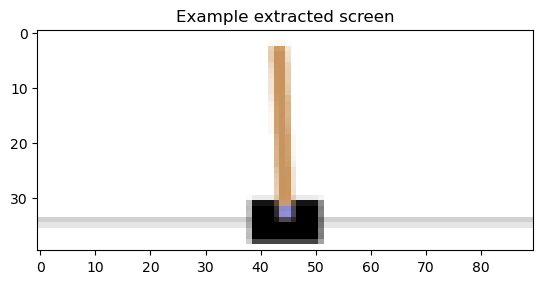

In [5]:
# Our network takes an image as input
# We need to get the image that show the state of our environement
# However we only need the image of the cart and pole to determine the action
# Thus we create an image(40x90) centered around the cart 

resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])


def get_cart_location(screen_width):
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)

def get_screen():
    screen = env.render().transpose((2, 0, 1))

    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height*0.4):int(screen_height * 0.8)]
    view_width = int(screen_width * 0.6)
    cart_location = get_cart_location(screen_width)
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)

    screen = screen[:, :, slice_range]

    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)

    return resize(screen).unsqueeze(0)


env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),interpolation='none')
plt.title('Example extracted screen')
plt.show()

#### Hyperparameters

In [6]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 5

#### Create Policy of DQN

In [7]:
# Since the network needs the size of the image to initalize we geet a scrren and measure the dimensions to create the network
# Our get screen gives out a image of 3x40x90 


init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape

n_actions = env.action_space.n

policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)

#### Method to pick action based on state

In [8]:
# We are using the greedy approach where we use the policy 
# but sometime we pass a random action in hopes of achiving better performance

steps_done = 0

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

#### Method to plot peformance (time survived by agent per episode)

In [9]:
# A helper function that plots the amount time the agent survived for a given episode
# It also starts ploting the mean for episodes more than 100

episode_durations = []

def plot_durations(title):
    plt.figure()
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title(title)
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated

#### Method to optimize DQN

In [10]:
# Make a function for optimization that use back propogation 
# We use the Huber loss function and use RMSprop as our optimizer

def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)

    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

   
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()

    expected_state_action_values = (next_state_values * GAMMA) + reward_batch


    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
    
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

#### Random Agent w/o training

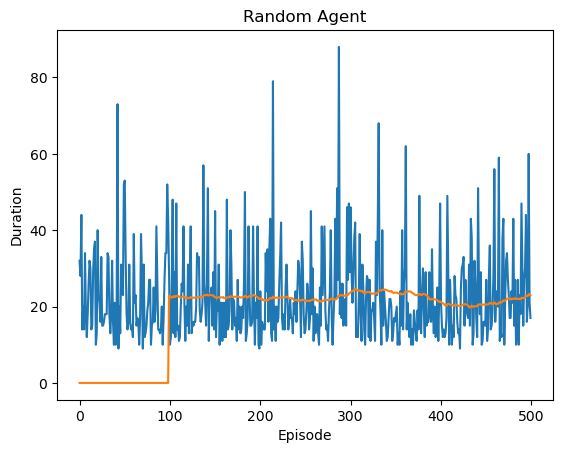

In [11]:
# We fisrt test a random agent by giving random actions to the agent
# we use the plot_duration() function to plot the time the agent survived for each episode

num_episodes = 500

for i_episode in range(num_episodes):

    for t in count():
        
        action = random.randrange(n_actions) 
        
        _, reward, done, _, _ = env.step(action)

        if done:
            episode_durations.append(t + 1)
            break

env.render()
plt.ioff()
plot_durations("Random Agent")
plt.show()

episode_durations = []
steps_done = 0

In [12]:
# Let us look at some results of using the random agent
# We use the provided module VideoRecoder by openAI
# This modules save the frame from a render of the environment and turns it into a mp4

#!!! I am using MoviePy for making the mp4, I searched a lot but could not suppress the otuputs from it

video = VideoRecorder(env,path="./video/No_Training.mp4")

env.reset()

for i in count():

  #Get a video of random agent
  env.render()
  video.capture_frame()
  
  #produces either 0 (left) or 1 (right).
  action = random.randrange(n_actions)
  
  output = env.step(action)
  
  observation = output[0] # Cart Position , Cart Velocity, Pole Angle, Pole Angular Velocity
  reward = output[1] # +1 for every step (Goal : keep the pole up as long as possible)
  done = output[2] # boolean : True-> when pole falls (pole angle more than 12, postioion more than 2.4)
  
  print("step", i, observation, reward, done)
  
  if done:
    break

video.close()

step 0 [-0.0062278  -0.16740009 -0.01026934  0.2542552 ] 1.0 False
step 1 [-0.00957581  0.02786697 -0.00518424 -0.04164908] 1.0 False
step 2 [-0.00901847  0.22306287 -0.00601722 -0.33596316] 1.0 False
step 3 [-0.00455721  0.41826993 -0.01273648 -0.6305375 ] 1.0 False
step 4 [ 0.00380819  0.6135673  -0.02534723 -0.9272042 ] 1.0 False
step 5 [ 0.01607954  0.4187966  -0.04389131 -0.64259326] 1.0 False
step 6 [ 0.02445547  0.224313   -0.05674318 -0.36404878] 1.0 False
step 7 [ 0.02894173  0.03004148 -0.06402416 -0.08978403] 1.0 False
step 8 [ 0.02954256  0.22601992 -0.06581984 -0.40195963] 1.0 False
step 9 [ 0.03406296  0.03189028 -0.07385903 -0.13073277] 1.0 False
step 10 [ 0.03470076  0.22798827 -0.07647368 -0.44577262] 1.0 False
step 11 [ 0.03926053  0.03402682 -0.08538914 -0.17814215] 1.0 False
step 12 [ 0.03994106  0.23026036 -0.08895198 -0.4964939 ] 1.0 False
step 13 [ 0.04454627  0.03649791 -0.09888186 -0.23311673] 1.0 False
step 14 [ 0.04527623  0.23288347 -0.10354419 -0.55528   ] 

Moviepy - Done !
Moviepy - video ready ./video/No_Training.mp4


In [14]:
from IPython.display import HTML

HTML("""
<video controls>
    <source src = "%s" type ="video/mp4">
</video>
"""%"video/No_Training.mp4"
)

#### Agent Trained for 200 Episodes (small amount of time)

In [15]:
# Reinitialize all the needed variables so we can train a agent for a small amount of time

init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape

n_actions = env.action_space.n

policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)

Complete


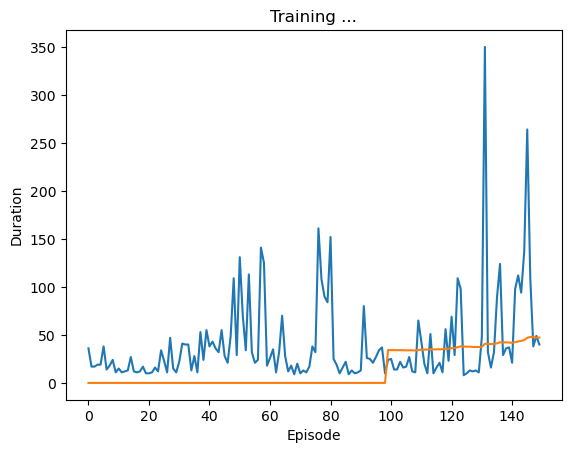

In [16]:
# We will train the agent for 150 episodes
# We will use our select_action() function to pick the action ouputed by the netwrok or the randomly generated action
# The we will perform optimization of the policy based on the transitions saved in the memory
# We will update our target_net every TARGET_UPDATE interval

num_episodes = 150
for i_episode in range(num_episodes):
    
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    
    for t in count():

        action = select_action(state)
        _, reward, done, _, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)

        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        memory.push(state, action, next_state, reward)

        state = next_state

        optimize_model()
        if done:
            episode_durations.append(t + 1)
            break

        if t % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())

print('Complete')

episode_durations = []
steps_done = 0

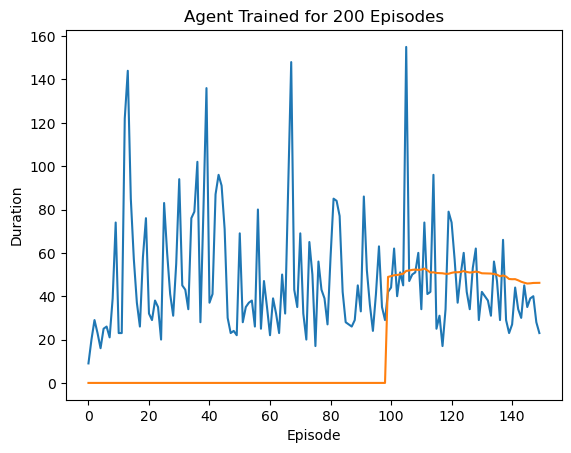

In [17]:
# Next we will check how the agent performs using the plot_duration() function

num_episodes = 150
for i_episode in range(num_episodes):
    # Initialize the environment and state
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    for t in count():
        
        action = select_action(state)
        _, reward, done, _, _ = env.step(action.item())

        last_screen = current_screen
        current_screen = get_screen()
        
        if not done:
            state = current_screen - last_screen
        else:
            episode_durations.append(t + 1)
            break
   

env.render()
plt.ioff()
plot_durations("Agent Trained for 200 Episodes")
plt.show()

episode_durations = []
steps_done = 0

# We see that on average the agent stays alive fro longer duration than the random agent

In [18]:
# We can also visualize how the agent perform using the VideoRecoder module

video = VideoRecorder(env,path="./video/Trained_200_episodes.mp4")

done = False
i = 0 

env.reset()
last_screen = get_screen()
current_screen = get_screen()
state = current_screen - last_screen

while (~done) :
      
  env.render()
  video.capture_frame()
      
  action = select_action(state)
  observation,reward,done,_,info = env.step(action.item())
  
  print("step", i, observation, reward, done, info)

  last_screen = current_screen
  
  current_screen = get_screen()
  if not done:
    state = current_screen - last_screen
  else:
    break
  
  i = i+1

video.close()
env.close()

step 0 [ 0.02512044 -0.15891905 -0.00334383  0.2941418 ] 1.0 False {}
step 1 [ 0.02194205 -0.35399318  0.002539    0.5857682 ] 1.0 False {}
step 2 [ 0.01486219 -0.15890688  0.01425437  0.2938862 ] 1.0 False {}
step 3 [ 0.01168405 -0.35422912  0.02013209  0.5910305 ] 1.0 False {}
step 4 [ 0.00459947 -0.54962707  0.0319527   0.8899864 ] 1.0 False {}
step 5 [-0.00639307 -0.7451677   0.04975243  1.19254   ] 1.0 False {}
step 6 [-0.02129642 -0.55072427  0.07360324  0.9158571 ] 1.0 False {}
step 7 [-0.03231091 -0.7467602   0.09192038  1.2307347 ] 1.0 False {}
step 8 [-0.04724611 -0.9429364   0.11653507  1.5507432 ] 1.0 False {}
step 9 [-0.06610484 -0.74938935  0.14754993  1.2965755 ] 1.0 False {}
step 10 [-0.08109263 -0.5564169   0.17348145  1.0534846 ] 1.0 False {}
step 11 [-0.09222097 -0.36396605  0.19455114  0.8198894 ] 1.0 False {}
step 12 [-0.09950029 -0.56114227  0.21094893  1.1669118 ] 1.0 True {}
Moviepy - Building video ./video/Trained_200_episodes.mp4.
Moviepy - Writing video ./vid

Moviepy - Done !
Moviepy - video ready ./video/Trained_200_episodes.mp4


In [19]:
from IPython.display import HTML

HTML("""
<video controls>
    <source src = "%s" type ="video/mp4">
</video>
"""%"video/Trained_200_episodes.mp4"
)

#### Agent Trained for 1000 Episodes (Large amount of time)

In [20]:
# We repeat all the steps and train the agen for a longer time now

init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape

n_actions = env.action_space.n

policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)

Complete


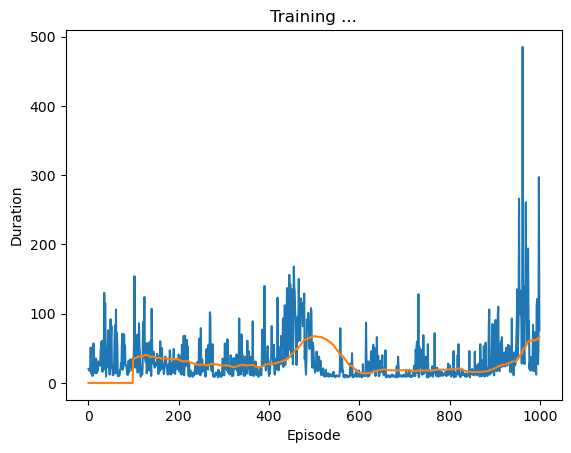

In [21]:
# This time we will train the agent for 1000 episodes

num_episodes = 1000

for i_episode in range(num_episodes):

    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    for t in count():
        
        action = select_action(state)
        _, reward, done, _, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)

        last_screen = current_screen
        current_screen = get_screen()
        
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        memory.push(state, action, next_state, reward)

        state = next_state
        
        optimize_model()
        if done:
            episode_durations.append(t + 1)
            break

        if t % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())

print('Complete')

episode_durations = []
steps_done = 0


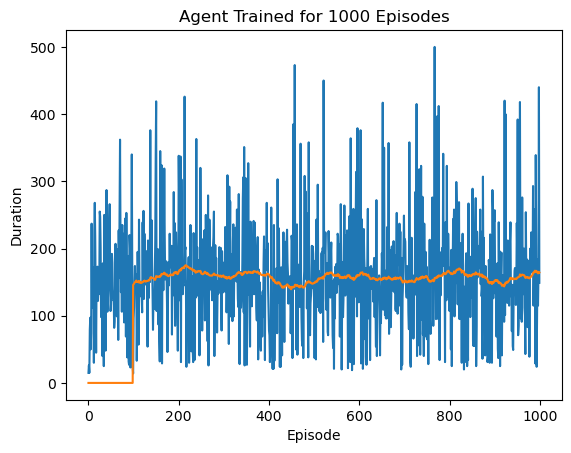

In [22]:

num_episodes = 1000

for i_episode in range(num_episodes):

    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    
    for t in count():
        

        action = select_action(state)
        _, reward, done, _, _ = env.step(action.item())

        last_screen = current_screen
        current_screen = get_screen()
        
        if not done:
            state = current_screen - last_screen
        else:
            episode_durations.append(t + 1)
            break
            

env.render()
plt.ioff()
plot_durations("Agent Trained for 1000 Episodes")
plt.show()

episode_durations = []
steps_done = 0

# We obsevrve that the agent stays alive more than the previous agent on average

In [29]:
video = VideoRecorder(env,path="./video/Trained_1000_episodes.mp4")

done = False
i = 0 

env.reset()
last_screen = get_screen()
current_screen = get_screen()
state = current_screen - last_screen

while (~done) :
      
  env.render()
  video.capture_frame()
      
  action = select_action(state)
  observation,reward,done,_,info = env.step(action.item())
  
  print("step", i, observation, reward, done, info)
  
  # Observe new state
  last_screen = current_screen
  
  current_screen = get_screen()
  if not done:
    state = current_screen - last_screen
  else:
    break
  
  i = i+1

video.close()
env.close()

step 0 [ 0.02575617  0.17858039 -0.01982585 -0.26815364] 1.0 False {}
step 1 [ 0.02932777 -0.0162531  -0.02518892  0.01821075] 1.0 False {}
step 2 [ 0.02900271  0.17922087 -0.02482471 -0.28231195] 1.0 False {}
step 3 [ 0.03258713 -0.01553836 -0.03047095  0.00243916] 1.0 False {}
step 4 [ 0.03227636  0.18000704 -0.03042217 -0.29969984] 1.0 False {}
step 5 [ 0.0358765  -0.01466837 -0.03641616 -0.01676459] 1.0 False {}
step 6 [ 0.03558313 -0.20924966 -0.03675146  0.26420984] 1.0 False {}
step 7 [ 0.03139814 -0.4038283  -0.03146726  0.5450782 ] 1.0 False {}
step 8 [ 0.02332157 -0.5984943  -0.02056569  0.8276828 ] 1.0 False {}
step 9 [ 0.01135169 -0.40309727 -0.00401204  0.5286034 ] 1.0 False {}
step 10 [ 0.00328974 -0.20791909  0.00656003  0.23465893] 1.0 False {}
step 11 [-0.00086864 -0.01289148  0.01125321 -0.05594756] 1.0 False {}
step 12 [-0.00112647  0.18206732  0.01013426 -0.3450589 ] 1.0 False {}
step 13 [ 0.00251488 -0.01319731  0.00323308 -0.04919755] 1.0 False {}
step 14 [ 0.0022

Moviepy - Done !
Moviepy - video ready ./video/Trained_1000_episodes.mp4


In [30]:
from IPython.display import HTML

HTML("""
<video controls>
    <source src = "%s" type ="video/mp4">
</video>
"""%"video/Trained_1000_episodes.mp4"
)